In [1]:
from pandas import read_csv, DataFrame, concat, Series
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import numpy as np

<ipython-input-1-3d4f8a3edb27>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

shampoo_sales = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
shampoo_sales.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

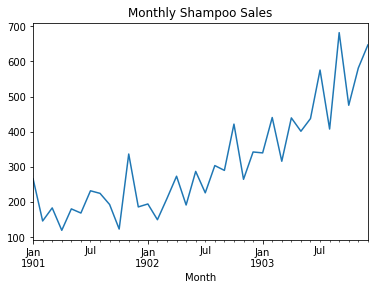

In [3]:
shampoo_sales.plot()
plt.title('Monthly Shampoo Sales')
plt.show()

#### The time series is not stationary as there is an obvious trend in the data.

In [5]:
# Prepare the time series data for use with an LSTM model
def timeseries_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
# Differencing will remove the trend in the time series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        diff_value = dataset[i] - dataset[i - interval]
        diff.append(diff_value)
    return Series(diff)

In [7]:
def scale(data_diff):
    scaler = MinMaxScaler(feature_range=[-1, 1])
    data_scaled = scaler.fit_transform(data_diff)
    data_scaled = data_scaled.reshape(len(data_scaled), 1)
    return scaler, data_scaled

In [8]:
n_lag = 1
n_seq = 3
n_test = 10
n_epoch = 1500
n_batch = 1
n_hidden = 1

In [9]:
data_raw = shampoo_sales.values

In [16]:
# removing the trend by differencing the data one time step
data_diff = difference(data_raw, 1).values
data_diff = data_diff.reshape(len(data_diff), 1)

In [17]:
# scaling the values between [-1, 1]
scaler, data_scaled = scale(data_diff)

In [18]:
# Transforing time series to a supervised classification format
data = timeseries_to_supervised(data_scaled, n_lag, n_seq)
data.head()

,var1(t-1),var1(t),var1(t+1),var1(t+2)
1,-0.639992,0.013926,-0.405945,0.112866
2,0.013926,-0.405945,0.112866,-0.189773
3,-0.405945,0.112866,-0.189773,0.122428
4,0.112866,-0.189773,0.122428,-0.171066
5,-0.189773,0.122428,-0.171066,-0.272501


In [19]:
# I'll use the last n_test samples for testing the model and 
# the rest for training the model
train, test = data[0:-n_test], data[-n_test:]
test

,var1(t-1),var1(t),var1(t+1),var1(t+2)
23,0.182706,-0.151528,0.277905,-0.658283
24,-0.151528,0.277905,-0.658283,0.372272
25,0.277905,-0.658283,0.372272,-0.298691
26,-0.658283,0.372272,-0.298691,0.009354
27,0.372272,-0.298691,0.009354,0.433382
28,-0.298691,0.009354,0.433382,-0.838703
29,0.009354,0.433382,-0.838703,1.000000
30,0.433382,-0.838703,1.000000,-1.000000
31,-0.838703,1.000000,-1.000000,0.299938
32,1.000000,-1.000000,0.299938,0.131989


In [20]:
def fit_lstm(train, n_lag, n_seq, n_batch, n_epoch, n_hidden):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(n_hidden, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(n_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [44]:
# one-step forecast function
def forecast_lstm(model, X, n_batch):
    print(X)
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

In [22]:
# Invert differenced forecast
def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [49]:
# Inverting data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        
        inverted.append(inv_diff)
    return inverted

In [24]:
# Evaluating the forecasted values
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [54]:
def plot_forecasts(series, forecasts, n_test):
    plt.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    
    plt.show()

In [57]:
lstm_model = fit_lstm(train.values, n_lag, n_seq, n_batch, n_epoch, n_hidden)

In [26]:
forecasts = []
for i in range(len(test)):
    X, y = test.values[i, 0:n_lag], test.values[i, n_lag:]
    forecast = forecast_lstm(lstm_model, X, n_batch)
    forecasts.append(forecast)

In [27]:
# Inverse transforming forecasts and test
forecasts = inverse_transform(shampoo_sales, forecasts, scaler, n_test+2)

In [28]:
actual = [row[n_lag:] for row in test.values]
actual = inverse_transform(shampoo_sales, actual, scaler, n_test+2)

In [29]:
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 120.549903
t+2 RMSE: 84.719123
t+3 RMSE: 105.343042


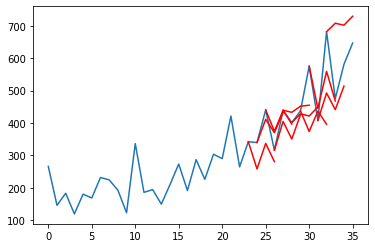

In [55]:
plot_forecasts(shampoo_sales, forecasts, n_test+2)